# Projeto de Transfer Learning em Python - Bootcamp Unimed-BH

## 1 - Introdução 

O projeto consiste em aplicar o método de Transfer Learning em uma rede de Deep Learning na linguagem Python. 

De um modo geral, a aprendizagem de transferência refere-se ao processo de alavancar o conhecimento aprendido em um modelo para o treinamento de outro modelo. Mais especificamente, o processo envolve pegar uma rede neural existente que foi previamente treinada para um bom desempenho em um conjunto de dados maior e usá-la como base para um novo modelo que aproveita a precisão da rede anterior para uma nova tarefa. Este método tornou-se popular nos últimos anos para melhorar o desempenho de uma rede neural treinada em um pequeno conjunto de dados; a intuição é que o novo conjunto de dados pode ser muito pequeno para ser treinado para um bom desempenho por si só, mas sabemos que a maioria das redes neurais treinadas para aprender recursos de imagem geralmente aprendem recursos semelhantes de qualquer maneira, especialmente nas camadas iniciais, onde são mais genéricos (detectores de borda, bolhas, e assim por diante).

### Fontes

O dataset utilizado engloba duas classes: gatos e cachorros. Uma descrição da base de dados pode ser visualizada neste link: <https://www.tensorflow.org/datasets/catalog/cats_vs_dogs.> 

Já o dataset para download pode ser acessado por meio deste outro link: <https://www.microsoft.com/en-us/download/details.aspx?id=54765.>



## 2 - Importando Bibliotecas e Instalando Dependências 

**Utilizando o Anaconda**

`conda install -c conda-forge tensorflow`

or 

`pip install tensorflow`

In [1]:
# manipulação e visualização de dados
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile as zf


# modelo
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 3 - Dataset

In [ ]:
## download do data set
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

## extrair o arquivo
files = zf.ZipFile("kagglecatsanddogs_5340.zip",'r')
files.extractall()
files.close() 

## listar a pasta 
#!dir PetImages
!ls PetImages

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   114M      0  0:00:06  0:00:06 --:--:--  122M
Cat  Dog


### Eliminando Imagens Corrompidas

In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f'Imagens Deletadas: {num_skipped}')
# print("Deleted %d images" % num_skipped)

Imagens Deletadas: 1590


### Gerando um Dataset

In [2]:
# tamanho da imagem em pixel
image_size = (180, 180)
# grupo de 32 imagens para treinamento
batch_size = 32

# daset para o treino
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# dataset para validação
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


### Visualização das Imagens

Aqui vemos que imagens de cachorros estão rotuladas com "1" e imagens de gato com "0".

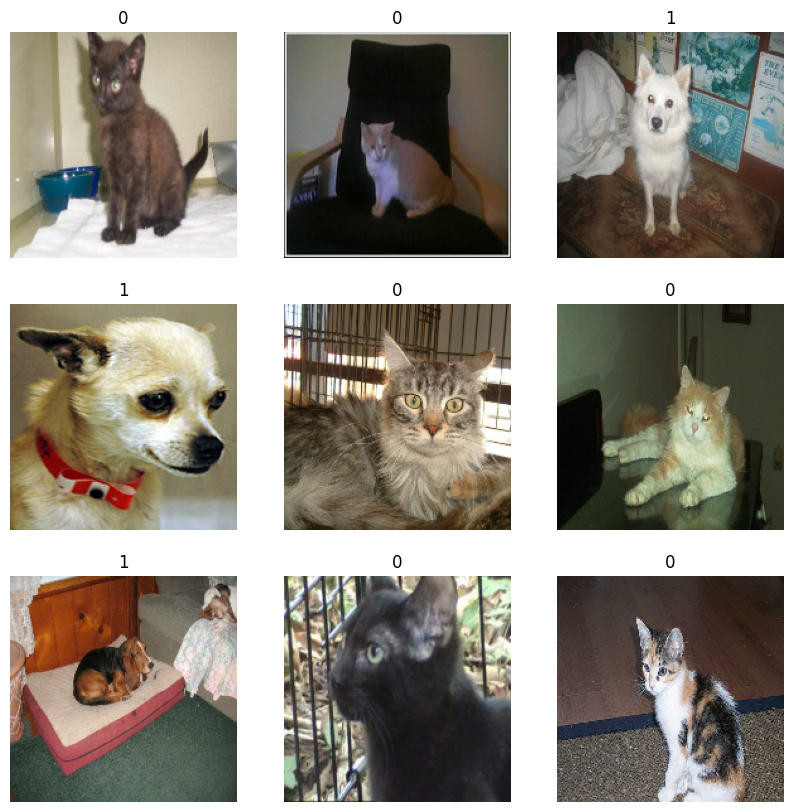

In [3]:
plt.figure(figsize=(10, 10))
# .take -> amostrar a próxima imagem
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Aumento Artificial do Dataset

Quando o dataset de imagens é limitado, é uma boa prática gerar mais amostras de imagens artificialmente. Transformações como inversão horizontal aleatória ou pequenas rotações aleatórias são implementadas para o aumento do número de imagens utilizadas no treinamento, sem alterar a realidade do dataset. Isso ajuda a expor o modelo a diferentes aspectos dos dados de treinamento enquanto diminui o overfitting.


In [4]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


Visualizar as imagens criadas artificialmente

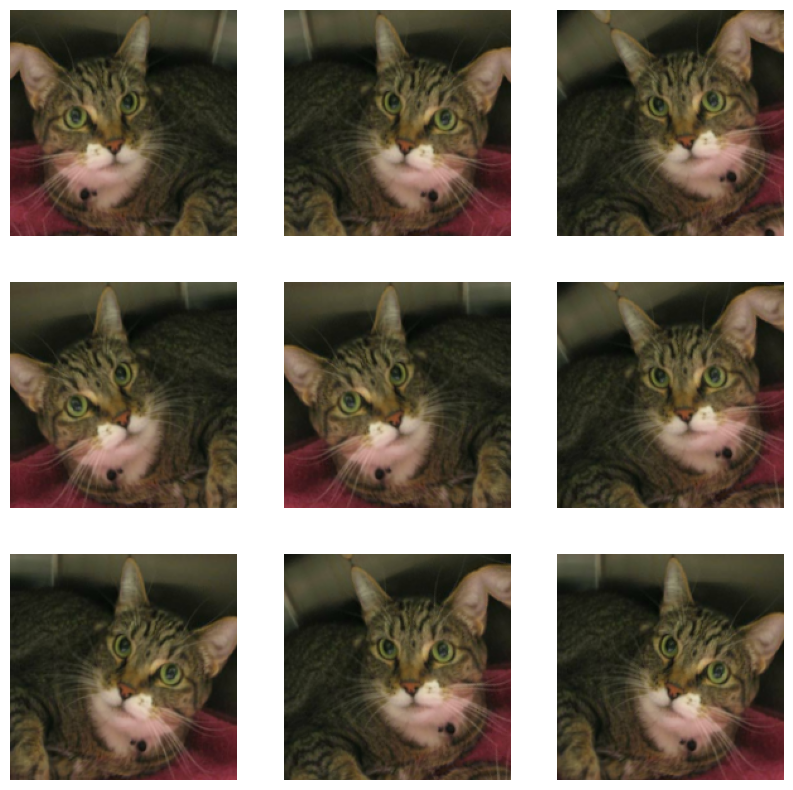

In [5]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


### Normalizar o Dado

O tamanho das imagens já foi normalizado. No entanto, o canal RGB está em valores de tons de cinza [0, 255]. Para redes neurais, geralmente esse valor tem que ser bem menor. Vamos normalizar esses valores para [0, 1] usando camada *rescaling* no começo do nosso modelo.

O código abaixa é utilizado para normalizar o dado antes de começar o treinamento (fora do modelo).

In [6]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))


### Configurando o Dataset para Performance



In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


## 4 - Modelo

Função para construção do modelo deep learning com Keras.

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Treinamento

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/50
586/586 [==============================] - 193s 307ms/step - loss: 0.6135 - accuracy: 0.6729 - val_loss: 0.6921 - val_accuracy: 0.6038
Epoch 2/50
586/586 [==============================] - 180s 307ms/step - loss: 0.4358 - accuracy: 0.7990 - val_loss: 0.5325 - val_accuracy: 0.7873
Epoch 3/50
586/586 [==============================] - 180s 307ms/step - loss: 0.3582 - accuracy: 0.8444 - val_loss: 0.3028 - val_accuracy: 0.8718
Epoch 4/50
586/586 [==============================] - 180s 307ms/step - loss: 0.3003 - accuracy: 0.8714 - val_loss: 0.2710 - val_accuracy: 0.8877
Epoch 5/50
586/586 [==============================] - 180s 307ms/step - loss: 0.2598 - accuracy: 0.8913 - val_loss: 0.5469 - val_accuracy: 0.7651
Epoch 6/50
586/586 [==============================] - 182s 309ms/step - loss: 0.2229 - accuracy: 0.9060 - val_loss: 0.8073 - val_accuracy: 0.7029
Epoch 7/50
586/586 [==============================] - 180s 306ms/step - loss: 0.2026 - accuracy: 0.9157 - val_loss: 0.3133 -

### Executar inferência em novos dados


Observe que o aumento e a eliminação de dados estão inativos no momento da inferência.

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(f"This image is {100 * (1 - score):.2f}percent cat and {100 * score:.2f} percent dog.")


## Bugs

### Versão do Tensorflow 
- The specific function (tf.keras.preprocessing.image_dataset_from_directory) is not available under TensorFlow v2.1.x or v2.2.0 yet. It is only available with the tf-nightly builds and is existent in the source code of the master branch.
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
- For more information about installing nightly builds of TensorFlow, you can refer to https://www.tensorflow.org/install or use
- pip install tf-nightly

### Tempo

- Se demorar muito o treinamento, usar a gpu no google colab

## Referências

- [Keras](https://keras.io/about/)
- [Tutorial Rede Neural Convolucional (CNN) com keras](https://www.tensorflow.org/tutorials/images/cnn)
- [Image Classification from Scratch](https://keras.io/examples/vision/image_classification_from_scratch/)